# Stochastic NN on plane sums

In [1]:
import numpy as np
from matplotlib import pylab as plt

In [2]:
import src.operate_datasets    as operate_datasets
import src.model_visualisation as model_visualisation
import src.model_evaluation    as model_evaluation

Welcome to JupyROOT 6.18/00


## Load data

In [3]:
full_X, full_y = operate_datasets.load_dataset('~/snd_data/new_dataset/', 'longitudal')

X_train, y_train, X_test, y_test = operate_datasets.split_dataset(full_X, full_y)

In [4]:
X_train.shape

(108000, 13)

In [5]:
#X_train = X_train.reshape(-1, 1)
#y_train = y_train.reshape(-1, 1)

#X_test = X_test.reshape(-1, 1)
#y_test = y_test.reshape(-1, 1)

In [6]:
min_clip = 0
#X_train, y_train = operate_datasets.clip_dataset(X_train, y_train, min_clip)

## Fit model

In [7]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.distributions import constraints
from torch.optim.lr_scheduler import ReduceLROnPlateau

import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer.autoguide import AutoDiagonalNormal
from pyro.infer import SVI, Trace_ELBO, Predictive

In [8]:
X_tens = torch.tensor(X_train).float()
y_tens = torch.tensor(y_train).float()

X_test_tens = torch.tensor(X_test).float()
y_test_tens = torch.tensor(y_test).float()

In [9]:
X_tens.shape

torch.Size([108000, 13])

In [10]:
class BNN(PyroModule):
    def __init__(self, inp_dim, hid_dim):
        super().__init__()
        
        self.fc1 = PyroModule[nn.Linear](inp_dim, hid_dim)
        self.fc2 = PyroModule[nn.Linear](hid_dim, hid_dim)
        self.fc3 = PyroModule[nn.Linear](hid_dim, 1)

        # register random values that Pyro will work with
        self.fc1.weight = PyroSample(dist.Normal(0., 1.).expand([hid_dim, inp_dim]).to_event(2))
        self.fc1.bias   = PyroSample(dist.Normal(0., 1.).expand([hid_dim]).to_event(1))

        self.fc2.weight = PyroSample(dist.Normal(0., 1.).expand([hid_dim, hid_dim]).to_event(2))
        self.fc2.bias   = PyroSample(dist.Normal(0., 1.).expand([hid_dim]).to_event(1))

        self.fc3.weight = PyroSample(dist.Normal(0., 1.).expand([1, hid_dim]).to_event(2))
        self.fc3.bias   = PyroSample(dist.Normal(0., 1.).expand([1]).to_event(1))
        return       


    def forward(self, x, y):
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        mu = self.fc3(x).squeeze()

        # Pyro's sampling
        sigma = pyro.sample("sigma", dist.Uniform(0., 1.))
        
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mu, sigma), obs=y.squeeze())
        
        return mu

In [11]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [12]:
def run_training(num_iter):
    model = BNN(X_tens[0].shape[0], 8)    
    guide = AutoDiagonalNormal(model) 

    predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("obs", "_RETURN"))
    
    #adam = pyro.optim.Adam({'lr' : 1e-1})
    adam = pyro.optim.ReduceLROnPlateau({'optimizer'  : torch.optim.Adam, 
                                         'optim_args' : {'lr' : 1e-1},
                                         'patience'   : 1,
                                         'verbose'    : True,
                                         'factor'     : 0.1})

    svi = SVI(model, guide, adam, loss=Trace_ELBO())
    
    pyro.clear_param_store()

    loss_arr = []

    for j in range(num_iter):
        running_loss = 0

        loss = svi.step(X_tens, y_tens)
        running_loss += loss

        loss_arr.append(running_loss)

        if (j + 1) % 50 == 0:
            print("[iteration %04d] loss: %.4f lr %g" % (j + 1, loss, 123))

    return model, loss_arr, predictive

In [13]:
# get predictions on the full dataset for analysis

from pyro.infer import Predictive

def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std":  torch.std(v, 0),
            "5%":   v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%":  v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

In [14]:
model, loss_arr, predictive = run_training(1000)

[iteration 0050] loss: 631590.8237 lr 123
[iteration 0100] loss: 599105.1047 lr 123
[iteration 0150] loss: 250390.4799 lr 123
[iteration 0200] loss: 95720.8916 lr 123
[iteration 0250] loss: 1016281.0659 lr 123
[iteration 0300] loss: 425400.7854 lr 123
[iteration 0350] loss: 106722.1779 lr 123
[iteration 0400] loss: 822528.6284 lr 123
[iteration 0450] loss: 235584.4069 lr 123
[iteration 0500] loss: 43977.2099 lr 123
[iteration 0550] loss: 93385.3622 lr 123
[iteration 0600] loss: 156958.8589 lr 123
[iteration 0650] loss: 86104.4734 lr 123
[iteration 0700] loss: 251656.6100 lr 123
[iteration 0750] loss: 41154.2510 lr 123
[iteration 0800] loss: 132376.9535 lr 123
[iteration 0850] loss: 277363.4504 lr 123
[iteration 0900] loss: 94952.5928 lr 123
[iteration 0950] loss: 63794.2738 lr 123
[iteration 1000] loss: 85438.6228 lr 123


In [15]:
samples = predictive(X_tens, y_tens)
pred_summary = summary(samples)

In [16]:
y_pred = pred_summary['_RETURN']['mean'].detach().cpu().numpy()

In [17]:
y_pred

array([0.20686114, 0.18144445, 0.25614148, ..., 0.19919781, 0.18085137,
       0.18933117], dtype=float32)

## Visualise results

In [18]:
X_sum = X_train.sum(axis=1).reshape(-1,1)

In [19]:
y_train = y_train.reshape(-1,1)
y_pred = y_pred.reshape(-1,1)

In [20]:
model_name = 'BNN on plane sums'
save_file_prefix = model_name.replace(' ', '-')

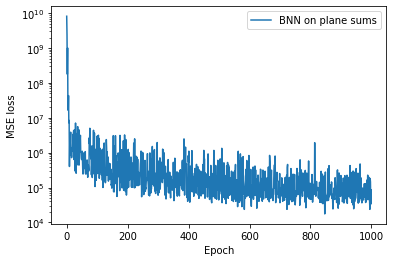

In [21]:
def plot_loss_arrays(loss_dict):
    for key in loss_dict.keys():
        plt.plot(loss_dict[key][0:], label=key)
    
    plt.yscale('log')
    #plt.xscale('log')
    plt.ylabel('MSE loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    return
    
plot_loss_arrays({model_name : loss_arr})

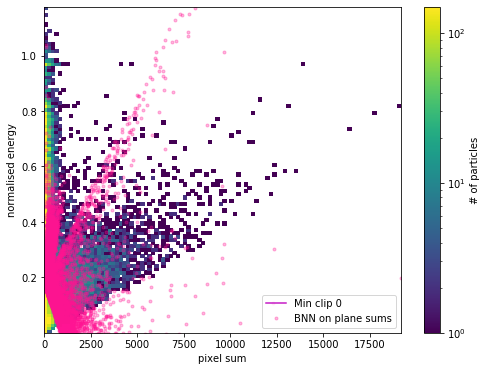

In [22]:
model_visualisation.plot_2d_energy_hist_clip(X_sum, y_train, y_pred, 0, model_name,
                                             save_file_prefix=save_file_prefix) 

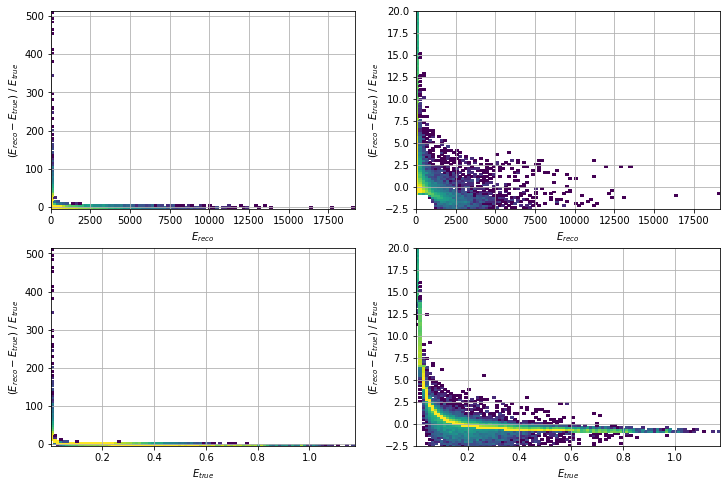

In [23]:
model_visualisation.plot_res_vs_energy(X_sum, y_train, y_pred, vmax=450,
                                       save_file_prefix=save_file_prefix) 

mean   = 1.81889e+00
std    = 7.50528e+00
median = 2.67331e-01


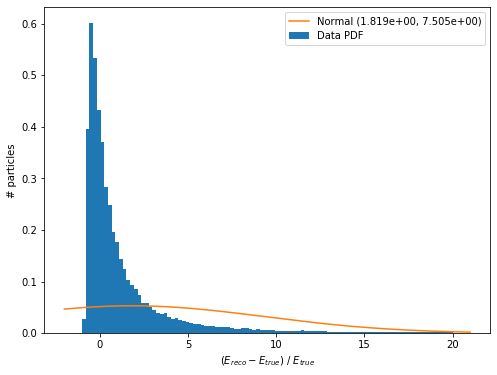

In [24]:
model_visualisation.plot_res_hist_fit(y_train, y_pred, [-1,20],
                                      save_file_prefix=save_file_prefix)

In [25]:
model_evaluation.save_scores(y_train, y_pred, save_file_prefix)

explained_variance_score -0.07594851660438584
max_error 3.9055875015762083
mean_absolute_error 0.1336078644032581
mean_squared_error 0.03467774421961074
median_absolute_error 0.10852847461813173
r2_score -0.08392517041331282


,BNN-on-plane-sums
explained_variance_score,-0.075949
max_error,3.905588
mean_absolute_error,0.133608
mean_squared_error,0.034678
median_absolute_error,0.108528
r2_score,-0.083925
avg_resolution,1.818890
std_resolution,7.505279


## Validation

In [26]:
X_sum_test = X_test.sum(axis=1).reshape(-1,1)
y_test = y_test.reshape(-1,1)

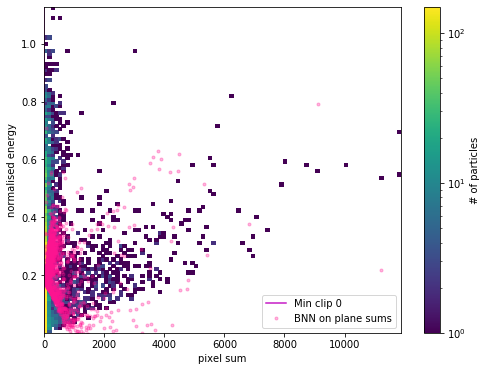

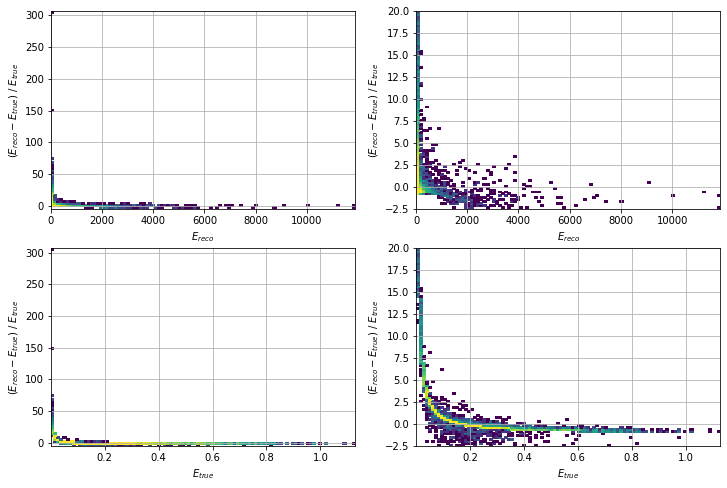

mean   = 1.72443e+00
std    = 5.69144e+00
median = 2.69799e-01


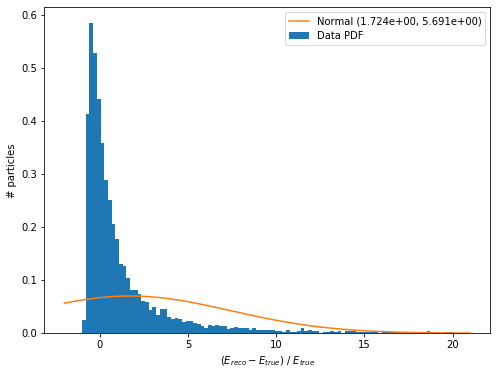

explained_variance_score -0.07199695270940287
max_error 2.012483756218351
mean_absolute_error 0.13460978964049375
mean_squared_error 0.03447597410324928
median_absolute_error 0.1092664479386986
r2_score -0.081009925887922


,BNN-on-plane-sums
explained_variance_score,-0.071997
max_error,2.012484
mean_absolute_error,0.134610
mean_squared_error,0.034476
median_absolute_error,0.109266
r2_score,-0.081010
avg_resolution,1.724431
std_resolution,5.691439


In [27]:
samples = predictive(X_test_tens, y_test_tens)
pred_summary = summary(samples)
y_pred_test = pred_summary['_RETURN']['mean'].detach().cpu().numpy()


model_visualisation.plot_2d_energy_hist_clip(X_sum_test, y_test, y_pred_test, min_clip, model_name,
                                             save_file_prefix=save_file_prefix) 

model_visualisation.plot_res_vs_energy(X_sum_test, y_test, y_pred_test, vmax=150,
                                       save_file_prefix=save_file_prefix)  

model_visualisation.plot_res_hist_fit(y_test, y_pred_test, [-1,20],
                                      save_file_prefix=save_file_prefix)

model_evaluation.save_scores(y_test, y_pred_test, save_file_prefix, 
                             folder_path=model_evaluation.TEST_SCORES_DIR)